c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing


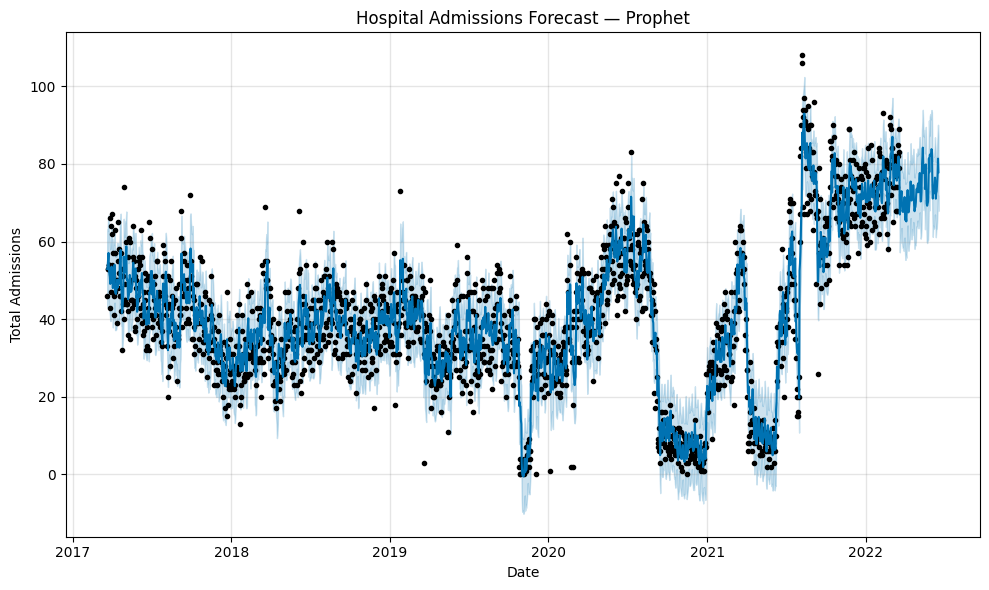


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21              66.971686    57.223794    75.893691
1820 2022-03-22              70.818686    60.963405    81.023018
1821 2022-03-23              69.423646    59.735632    79.045106
1822 2022-03-24              71.947935    61.947692    81.788992
1823 2022-03-25              72.980505    63.488451    83.228363
...         ...                    ...          ...          ...
1904 2022-06-14              72.972367    63.300363    82.005935
1905 2022-06-15              75.047284    65.148378    84.732093
1906 2022-06-16              77.232649    68.195184    87.449007
1907 2022-06-17              81.377748    71.957611    90.092100
1908 2022-06-18              77.865906    67.915680    87.303019

[90 rows x 4 columns]
Mean Absolute Error (MAE): 6.85
Mean Squared Error (MSE): 78.42
Root Mean Squared Error (RMSE): 8.86


In [1]:
# === Step 1: Install and import Prophet ===
# If not installed, uncomment below:
# !pip install prophet

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

hospital_data = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv")

# === Step 2: Prepare Data for Prophet ===
# Prophet expects two columns: 'ds' (date) and 'y' (target variable)

prophet_data = hospital_data.reset_index()[['ResidentDate', 'Total_Admissions']].rename(
    columns={'ResidentDate': 'ds', 'Total_Admissions': 'y'}
)

# Optional: Add exogenous features (holidays, etc.) separately if needed

# === Step 3: Add Regressors (optional) ===
# Prophet can take extra regressors — similar to exogenous variables in ARIMAX

exog_vars = [
    'Total_Admissions_Rolling_Max','Total_Admissions_Rolling_Min','Total_Admissions_Rolling_Std',
        'Total_Admissions_MA14','ResidentDate_weekday','temperature_max','temperature_min',
        'Total_Admissions_Lag7','precipitation','temp_range'
]  
exog = hospital_data[exog_vars]

m = Prophet()

# Add extra regressors
for col in exog_vars:
    m.add_regressor(col)

# Combine exog variables with target for training
prophet_full = pd.concat([prophet_data, hospital_data[exog_vars].reset_index(drop=True)], axis=1)

# === Step 4: Fit the Prophet Model ===
m.fit(prophet_full)

# === Step 5: Create Future DataFrame ===
future = m.make_future_dataframe(periods=90, freq='D')

# Add exogenous features to future dataframe
future_exog = hospital_data[exog_vars].iloc[-90:].reset_index(drop=True)
future = pd.concat([future.iloc[-90:].reset_index(drop=True), future_exog], axis=1)
future_full = pd.concat([prophet_full[['ds'] + exog_vars], future], axis=0)

# === Step 6: Forecast ===
forecast = m.predict(future_full)

# === Step 7: Visualization ===
m.plot(forecast)
plt.title("Hospital Admissions Forecast — Prophet")
plt.xlabel("Date")
plt.ylabel("Total Admissions")
plt.grid(True)
plt.tight_layout()
plt.show()


# === Step 8: Forecast Table ===
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
forecast_table = forecast_table.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Admissions',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
})

print("\nForecast Preview:")
print(forecast_table.head(90))


# === Step 9: Calculate Performance Metrics ===
# Split the data into training and testing sets
train_size = int(len(hospital_data) * 0.8)  # 80% for training
train, test = hospital_data.iloc[:train_size], hospital_data.iloc[train_size:]

# Prepare the test data for Prophet
test_prophet_data = test.reset_index()[['ResidentDate', 'Total_Admissions']].rename(
    columns={'ResidentDate': 'ds', 'Total_Admissions': 'y'}
)

# Prepare the future dataframe for the test set
future_test = m.make_future_dataframe(periods=len(test), freq='D')
future_test_exog = test[exog_vars].reset_index(drop=True)
future_test = pd.concat([future_test.iloc[-len(test):].reset_index(drop=True), future_test_exog], axis=1)

# Forecast on the test set
forecast_test = m.predict(future_test)

# Calculate performance metrics
mae = mean_absolute_error(test_prophet_data['y'], forecast_test['yhat'][-len(test):])
mse = mean_squared_error(test_prophet_data['y'], forecast_test['yhat'][-len(test):])
rmse = mse ** 0.5

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')